# Data Science template - Titanic Case

Deze notebook begeleidt je stap voor stap door de **Titanic**-case op Kaggle.
De focus ligt op de standaard Data Science workflow:

1. Probleemdefinitie en doel
2. Data-input & Data cleaning
3. Verkenning (EDA)
4. Feature engineering
5. Modelleren (baseline → verbeterde modellen)
6. **Voorspelling** en export van `submission.csv`

> 🎯 Doel: voorspel de kans dat een passagier de Titanic-vaart heeft overleefd (`Survived`).

## 0. Doel & Omgevings-setup

- Download `train.csv` en `test.csv` handmatig van de Titanic-competitiepagina en plaats ze in een bijvoorbeeld in dezelfde map als dit bestand.


In [3]:
# !python --version


## 1. Imports

In [19]:
import pandas as pd
import numpy as np

# Visualisatie
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & evaluatie
# import sklearn

# Hiermee laat je alle kolommen standaard zien
pd.set_option('display.max_columns', None)

## 2. Probleemdefinitie

- **Input**: passagiersgegevens zoals `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, etc.
- **Output**: binaire target `Survived` (0 = niet overleefd, 1 = overleefd).
- **Metric (Kaggle leaderboard)**: **Accuracy** op de testset (zonder labels).


## 3. Data inladen

In [5]:
# Je gaat werken met de train data. In de test data staan de Survived kolom niet ingevuld. Deze moet je dus zelf voorspellen.

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4. Snelle datacheck & Preprocessing

Waar missen we (rijen met) data? Je kan missende data invullen door bijvoorbeeld voor bepaalde soort data op een bepaalde manier in te vullen:

- Numeriek: imputatie (median) + scaling
- Categorisch: imputatie (most_frequent) + one-hot encoding

In [6]:
display(train.sample(5, random_state=42))
display(train.describe(include='all'))
train.isna().mean().sort_values(ascending=False)[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
Sex            0.000000
Parch          0.000000
SibSp          0.000000
dtype: float64

## 5. Verkennende Data Analyse (EDA)

> Tip: Voeg hier extra grafieken toe (bijv. histogrammen, boxplots, countplots per feature).


In [18]:
# Voorbeeld: verdeling overleven per geslacht
pd.crosstab(train['Sex'], train['Survived'], normalize='index')



Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


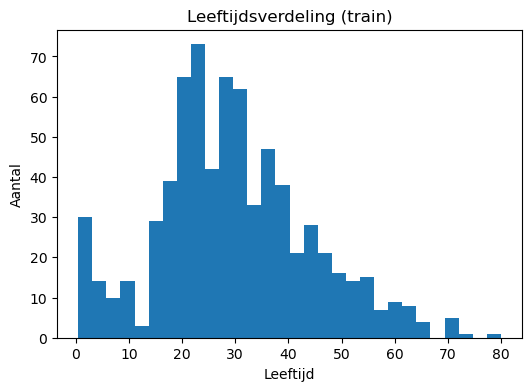

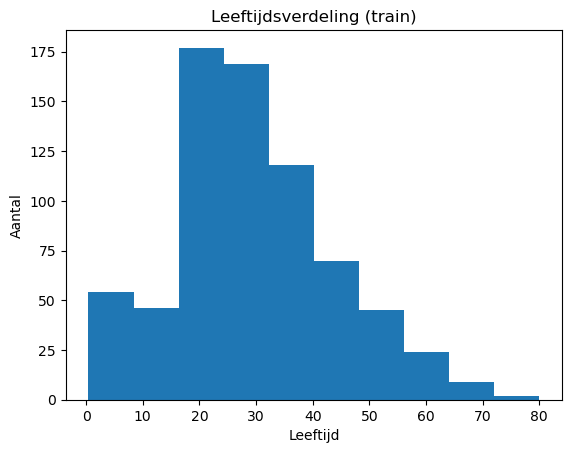

In [ ]:
# Voorbeeld: verdeling leeftijd (met eenvoudige imputatie voor visualisatie)
# we verwijderen simpelweg alle rijen waar geen leeftijd bekend is.
ages = train['Age'].dropna()
plt.figure(figsize=(6,4))
plt.hist(ages, bins=30)
plt.title('Leeftijdsverdeling (train)')
plt.xlabel('Leeftijd'); plt.ylabel('Aantal')
plt.show()

plt.hist(ages)
plt.title('Leeftijdsverdeling (train)')
plt.xlabel('Leeftijd'); plt.ylabel('Aantal')
plt.show()



In [14]:
# Oefening: voeg je eigen EDA toe
# Gebruik Seaborn in plaats van Matplotlib.
# TODO: tel bijvoorbeeld overlevingspercentage per Pclass, Embarked, Fare-quantiles (pd.qcut), etc.

## 6. Feature Engineering

Voeg hier zelf extra features toe (bijv. `Title` uit `Name`, `FamilySize = SibSp + Parch + 1`, indicatoren, etc.).

Zorg wel dat het relevant is voor je eigen onderzoek. Waar ligt je eigen focus.

In [15]:
# Je kan nu zelf features aanmaken invullen. 

## 7. Baseline model — np.where invullen

In [16]:
# === 3. Regelgebaseerde baseline met np.where ===
# Regel: vrouwen overleven altijd, jongens (<10 jaar) ook, anders niet
train_pred = np.where(
    (train['Sex'] == 'female') | ((train['Sex'] == 'male') & (train['Age'] < 10)),
    1, 0
)

## 8. Maak een eindmodel op volledige trainingsdata en voorspel op test

Hier kiezen we als voorbeeld het np.where model (of gebruik anders een ander model).


In [17]:
# === 4. Toepassen op testset ===
test_pred = np.where(
    (test['Sex'] == 'female') | ((test['Sex'] == 'male') & (test['Age'] < 10)),
    1, 0
)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("submission.csv aangemaakt!")
submission.head()

submission.csv aangemaakt!


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 9. Checklist & Volgende stappen

- [ ] Zorg dat er een duidelijke samenhang is tussen de grafieken -> Feature Engineering -> je uiteindelijke model! Dat is het belangrijkst.
- [ ] Laat geen grafieken zien waar je niks mee doet tijdens de presentatie.
- [ ] Zorg dat er dus een rode draad is in je verhaal. 

Voorbeeld: We hebben de focus gelegd op leeftijd -> EDA laat deze grafieken met leeftijd zien. We hebben met Feature Engineering nog leeftijdsgroepen aangemaakt -> We hebben in het model de leeftijden gebruikt. Dit is onze score.

- [ ] Eventueel EDA (een klein beetje) uitbreiden (meer grafieken, correlaties, outliers)
- [ ] Feature engineering verbeteren (wat is er relevant?)
- [ ] Meer modellen proberen (Logistic Regression? Sklearn)
- [ ] Submission inleveren op kaggle en kijken hoe goed je score is

Succes met de case!